
# ========================================
# 3. CHUẨN BỊ DỮ LIỆU CHO MARKET BASKET ANALYSIS
# ========================================

## PHẦN 1: CHUẨN BỊ DỮ LIỆU

###  3.1 Tạo transaction dataset


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
from itertools import combinations
import time

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("tab10")

In [2]:
df = pd.read_csv('cleaned_data (2).csv')
print(f"\n Đã load data: {df.shape[0]:,} transactions")


 Đã load data: 99,457 transactions


In [3]:
# Group by invoice_no để lấy danh sách categories
if all(col in df.columns for col in ['invoice_no', 'category']):
    transactions = df.groupby('invoice_no')['category'].apply(list).values.tolist()

    print(f"\n   Số transactions: {len(transactions):,}")
    print(f"   Trung bình items/transaction: {np.mean([len(t) for t in transactions]):.2f}")
    print(f"   Max items/transaction: {max([len(t) for t in transactions])}")
    print(f"   Min items/transaction: {min([len(t) for t in transactions])}")

    # Hiển thị ví dụ transactions
    print("\n  Ví dụ 5 transactions đầu tiên:")
    for i, trans in enumerate(transactions[:5], 1):
        print(f"    {i}. {trans}")



   Số transactions: 99,457
   Trung bình items/transaction: 1.00
   Max items/transaction: 1
   Min items/transaction: 1

  Ví dụ 5 transactions đầu tiên:
    1. ['Clothing']
    2. ['Cosmetics']
    3. ['Clothing']
    4. ['Books']
    5. ['Technology']


###  3.2 Phân tích items frequency


[2] PHÂN TÍCH ITEM FREQUENCY:

  Số categories duy nhất: 8

  Top 10 categories phổ biến nhất:
Clothing           34487
Cosmetics          15097
Food & Beverage    14776
Toys               10087
Shoes              10034
Souvenir            4999
Technology          4996
Books               4981
Name: count, dtype: int64


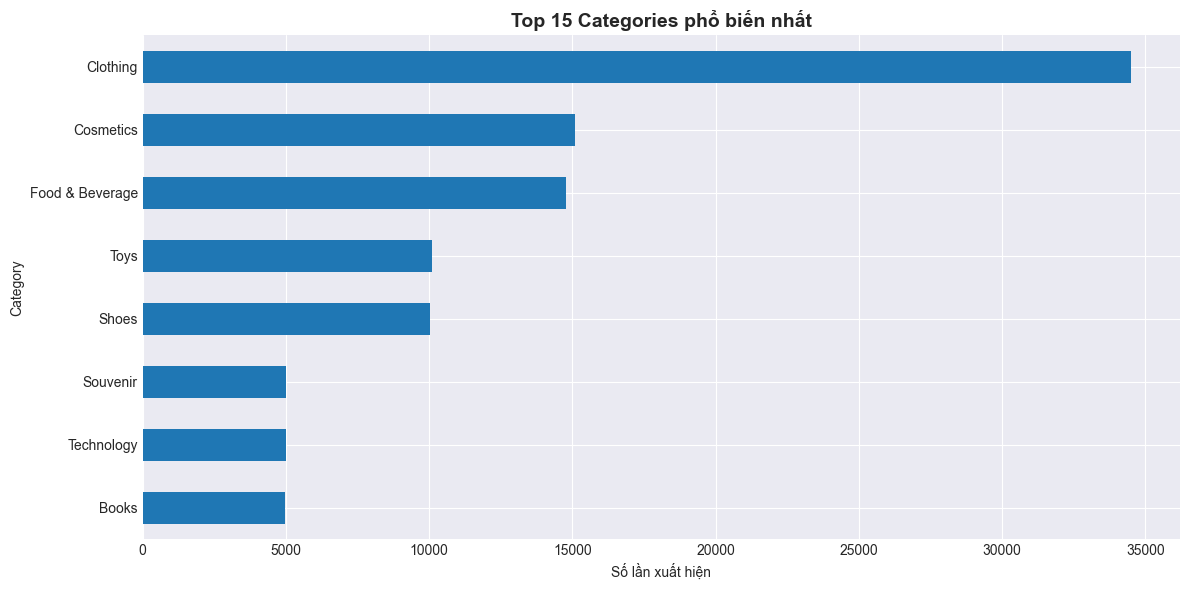


 Đã lưu: figures/01_item_frequency.png


In [4]:
print("\n[2] PHÂN TÍCH ITEM FREQUENCY:")

# Flatten all items
all_items = [item for sublist in transactions for item in sublist]
item_counts = pd.Series(all_items).value_counts()

print(f"\n  Số categories duy nhất: {len(item_counts)}")
print("\n  Top 10 categories phổ biến nhất:")
print(item_counts.head(10))
os.makedirs('figures', exist_ok=True)
# Visualize item frequency
plt.figure(figsize=(12, 6))
item_counts.head(15).plot(kind='barh')
plt.title('Top 15 Categories phổ biến nhất', fontsize=14, fontweight='bold')
plt.xlabel('Số lần xuất hiện')
plt.ylabel('Category')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('figures/01_item_frequency.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n Đã lưu: figures/01_item_frequency.png")


###  3.3 Chuyển đổi sang One-Hot Encoding

In [5]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print(f"   Shape: {df_encoded.shape}")
print(f"   Sparsity: {(1 - df_encoded.sum().sum() / (df_encoded.shape[0] * df_encoded.shape[1]))*100:.2f}%")

   Shape: (99457, 8)
   Sparsity: 87.50%


# ========================================
# 4. APRIORI ALGORITHM
# ========================================

###  4.1 Thử nghiệm với các giá trị min_support khác nhau

In [6]:
support_values = [0.01, 0.02, 0.03, 0.05]
apriori_results = {}

for min_sup in support_values:
    start_time = time.time()
    frequent_itemsets = apriori(df_encoded, min_support=min_sup, use_colnames=True)
    exec_time = time.time() - start_time

    apriori_results[min_sup] = {
        'itemsets': frequent_itemsets,
        'count': len(frequent_itemsets),
        'time': exec_time
    }

    print(f"\n  min_support={min_sup}:")
    print(f"    - Số frequent itemsets: {len(frequent_itemsets)}")
    print(f"    - Thời gian: {exec_time:.2f}s")


  min_support=0.01:
    - Số frequent itemsets: 8
    - Thời gian: 0.02s

  min_support=0.02:
    - Số frequent itemsets: 8
    - Thời gian: 0.01s

  min_support=0.03:
    - Số frequent itemsets: 8
    - Thời gian: 0.01s

  min_support=0.05:
    - Số frequent itemsets: 8
    - Thời gian: 0.01s


### 4.2 Chọn min_support tối ưu

In [7]:
optimal_min_support = 0.02  # Có thể điều chỉnh
print(f"\n[2] SỬ DỤNG min_support={optimal_min_support}:")

frequent_itemsets_apriori = apriori_results[optimal_min_support]['itemsets']
print(f"   Số frequent itemsets: {len(frequent_itemsets_apriori)}")

# Phân tích theo itemset size
print("\n  Phân bố theo kích thước itemset:")
itemset_sizes = frequent_itemsets_apriori['itemsets'].apply(len)
print(itemset_sizes.value_counts().sort_index())


[2] SỬ DỤNG min_support=0.02:
   Số frequent itemsets: 8

  Phân bố theo kích thước itemset:
itemsets
1    8
Name: count, dtype: int64


### 4.3 Generate Association Rules

In [8]:
# Thử nghiệm với các metrics và thresholds
metrics_configs = [
    {'metric': 'confidence', 'min_threshold': 0.3},
    {'metric': 'confidence', 'min_threshold': 0.5},
    {'metric': 'lift', 'min_threshold': 1.2}
]

rules_comparison = {}

for config in metrics_configs:
    try:
        rules = association_rules(frequent_itemsets_apriori,
                                 metric=config['metric'],
                                 min_threshold=config['min_threshold'])
        rules_comparison[f"{config['metric']}_{config['min_threshold']}"] = rules
        print(f"\n  {config['metric']} >= {config['min_threshold']}: {len(rules)} rules")
    except:
        print(f"\n  {config['metric']} >= {config['min_threshold']}: 0 rules")

# Chọn rules với confidence >= 0.3
rules_apriori = rules_comparison.get('confidence_0.3', pd.DataFrame())

if len(rules_apriori) > 0:
    print(f"\n[4] TOP 10 RULES (sorted by lift):")
    rules_sorted = rules_apriori.sort_values('lift', ascending=False).head(10)

    for idx, row in rules_sorted.iterrows():
        print(f"\n  Rule {idx + 1}:")
        print(f"    {list(row['antecedents'])} => {list(row['consequents'])}")
        print(f"    - Support: {row['support']:.4f}")
        print(f"    - Confidence: {row['confidence']:.4f}")
        print(f"    - Lift: {row['lift']:.4f}")


  confidence >= 0.3: 0 rules

  confidence >= 0.5: 0 rules

  lift >= 1.2: 0 rules


# ========================================
# 5. FP-GROWTH ALGORITHM
# ========================================

In [9]:
start_time = time.time()
frequent_itemsets_fpgrowth = fpgrowth(df_encoded, min_support=optimal_min_support, use_colnames=True)
fpgrowth_time = time.time() - start_time

print(f"   Số frequent itemsets: {len(frequent_itemsets_fpgrowth)}")
print(f"   Thời gian: {fpgrowth_time:.2f}s")

# Generate rules from FP-Growth
print("\n[2] GENERATE RULES FROM FP-GROWTH:")

try:
    rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth,
                                       metric='confidence',
                                       min_threshold=0.3)
    print(f"   Số rules: {len(rules_fpgrowth)}")

    print(f"\n[3] TOP 10 RULES (sorted by lift):")
    rules_fpg_sorted = rules_fpgrowth.sort_values('lift', ascending=False).head(10)

    for idx, row in rules_fpg_sorted.iterrows():
        print(f"\n  Rule {idx + 1}:")
        print(f"    {list(row['antecedents'])} => {list(row['consequents'])}")
        print(f"    - Support: {row['support']:.4f}")
        print(f"    - Confidence: {row['confidence']:.4f}")
        print(f"    - Lift: {row['lift']:.4f}")
except:
    rules_fpgrowth = pd.DataFrame()
    print("   Không tìm thấy rules!")

   Số frequent itemsets: 8
   Thời gian: 0.64s

[2] GENERATE RULES FROM FP-GROWTH:
   Số rules: 0

[3] TOP 10 RULES (sorted by lift):


# ========================================
# 6. COMPARISON: APRIORI VS FP-GROWTH
# ========================================

### SO SÁNH APRIORI VS FP-GROWTH


Algorithm  Frequent Itemsets  Association Rules  Execution Time (s)
  Apriori                  8                  0            0.012615
FP-Growth                  8                  0            0.638992


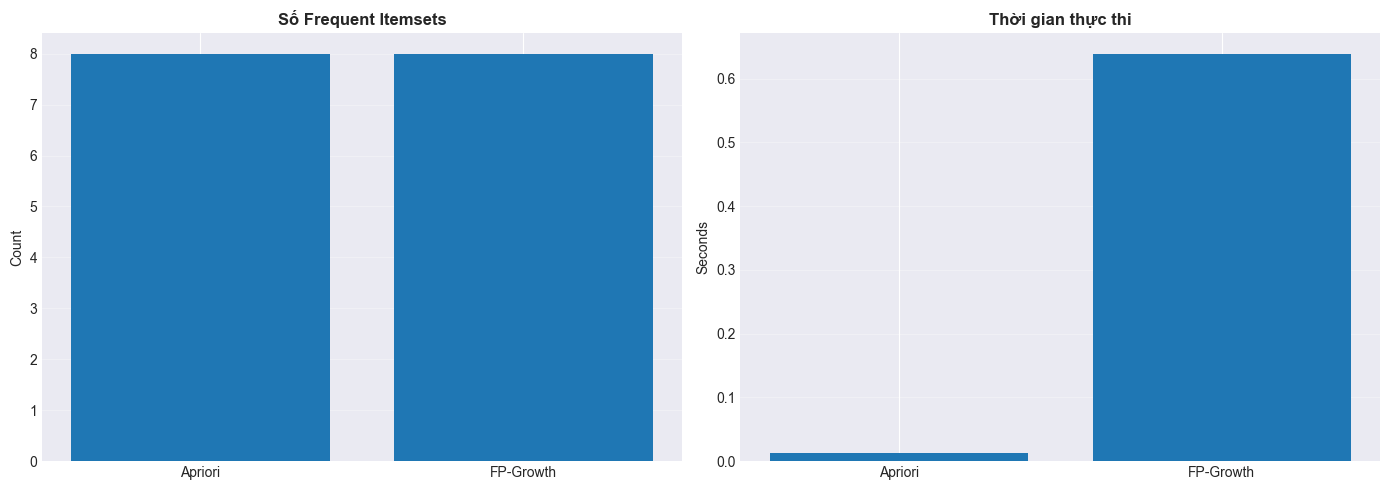


 Đã lưu: figures/02_algorithm_comparison.png


In [10]:
comparison_df = pd.DataFrame({
    'Algorithm': ['Apriori', 'FP-Growth'],
    'Frequent Itemsets': [len(frequent_itemsets_apriori), len(frequent_itemsets_fpgrowth)],
    'Association Rules': [len(rules_apriori), len(rules_fpgrowth)],
    'Execution Time (s)': [apriori_results[optimal_min_support]['time'], fpgrowth_time]
})

print("\n" + comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Frequent itemsets comparison
axes[0].bar(comparison_df['Algorithm'], comparison_df['Frequent Itemsets'])
axes[0].set_title('Số Frequent Itemsets', fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# Execution time comparison
axes[1].bar(comparison_df['Algorithm'], comparison_df['Execution Time (s)'])
axes[1].set_title('Thời gian thực thi', fontweight='bold')
axes[1].set_ylabel('Seconds')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figures/02_algorithm_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n Đã lưu: figures/02_algorithm_comparison.png")
